In [1]:
import os
try: # Check platform (Colab or Jupyter)
    from google.colab import drive
    drive.mount('/content/drive')
    my_drive = "/content/drive/My Drive/"
except:
    my_drive = os.path.expanduser("~") + "/drive/"

Mounted at /content/drive


In [2]:
import numpy as np, os, sys, time, pandas as pd, tensorflow as tf, random
start_time = time.time()
import keras
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
path = my_drive + "jöklar/"
sys.path.append(path + "src")
from util.util import install_if_missing
install_if_missing("rasterio")
import rasterio
from numpy import flatnonzero as find
from osgeo import gdal

In [3]:
# Define model type and data to use
modeltype = "unet"
augmentation = True
dataname = "lang"
model_path = path + "results/" + modeltype + "/"
data_path = path + "data/" + dataname + "/"
os.makedirs(model_path, exist_ok=True)
os.chdir(model_path)

In [4]:
def load_image_and_mask():
  # Load individual image and mask files, determine glacier border tiles
  n_channels = 13
  mask_files = [f for f in os.listdir(data_path) if f.startswith('mask-')]
  n_all = len(mask_files)
  img = np.zeros((n_all, 256, 256, 13), dtype='float')
  mask = np.zeros((n_all, 256, 256, 1))
  glacier_fraction = np.zeros(n_all)
  meta = []
  for i in range(n_all):
    mask_file = f"mask-{i:03d}.tif"
    img_file = f"img-{i:03d}.tif"
    dataset = gdal.Open(f"{data_path}/{mask_file}", gdal.GA_ReadOnly)
    band = dataset.GetRasterBand(1)
    mask_arr = band.ReadAsArray()[:,:,None]
    with rasterio.open(data_path + img_file) as f:
      img_arr = np.dstack([f.read(b) for b in range(1, n_channels + 1)])
      meta.append(f.meta)
    glacier_fraction[i] = np.sum(mask_arr != 0) / mask_arr.size
    img[i] = img_arr/10000
    mask[i] = mask_arr
  return img, mask

def find_border_indices(mask):
    glacier_fraction = [np.sum(m != 0)/m.size for m in mask]
    is_on_border = [0.01 < g < 0.99 for g in glacier_fraction]
    return find(is_on_border)

In [ ]:
image, mask = load_image_and_mask()
border_indices = find_border_indices(mask)
image.shape, image.dtype

197 105


((197, 256, 256, 13), dtype('float64'))

In [14]:
# Import project-specific packages

# NOTES
# deeplab-v3+ is copied more or less directly from the github repository
#    github.com/david8862/tf-keras-deeplabv3p-model-set
# (the original files are in the subdirectory from_github, cf differences.txt)
#
# unet is copied from...

match modeltype:
  case "unet":
    from models.unet import get_unet
  case "deeplab":
    install_if_missing("keras_applications")
    from models.deeplabv3p import model

In [11]:
# Read image data and data splits and define X and Y for training and test
npzfile = data_path + "lang.npz"
data = np.load(npzfile)
image = data["image"]
mask = data["mask"]
border_indices = find_border_indices(mask)
image.shape, len(border_indices)

105

In [15]:
def create_model(modeltype):
  match modeltype:
    case "unet":
      input_img = keras.layers.Input((256, 256, 13), name='img')
      Adam_params = {"learning_rate":1e-4, "clipnorm":1.0}
      model = get_unet(input_img, n_filters=64, dropout=0.2, batchnorm=True)

    case "deeplab":
      Adam_params = {"learning_rate":1e-4}
      get_deeplab = model.get_deeplabv3p_model
      model = get_deeplab(model_type='resnet50', num_classes=1,
                          model_input_shape=(256,256),
                          output_stride=16,
                          freeze_level=0,
                          weights_path=None,
                          training=True,
                          use_subpixel=False)

  model.compile(optimizer = Adam(**Adam_params),
                loss="binary_crossentropy",
                metrics=["accuracy"])
  model.save('model_first.keras')
  return model
  # NOTE: Saving weights only gives a file just as big as saving the whole model

In [16]:
def define_callbacks(modeltype):
  match modeltype:
    case "unet":
      early_stopping = EarlyStopping(patience=15, verbose=1)
      reduce_LR_on_plateau = ReduceLROnPlateau(factor=0.1,
                                              patience=7,
                                              min_lr=0.00001,
                                              verbose=1),

    case "deeplab":
      early_stopping = EarlyStopping(min_delta=0.01,
                                    patience=40,
                                    verbose=1,
                                    monitor='val_loss',
                                    restore_best_weights=True)
      reduce_LR_on_plateau = ReduceLROnPlateau(factor=0.1,
                                              patience=10,
                                              min_lr=1e-12,
                                              verbose=1)
  checkpoint_best = ModelCheckpoint('model_best.keras',
                                    verbose=1,
                                    monitor="val_loss",
                                    save_weights_only=True,
                                    save_best_only=True)
  checkpoint_last = ModelCheckpoint('model_last.keras',
                                    save_weights_only=True)
  callbacks = [
      EarlyStopping(patience=60, verbose=1),
      ReduceLROnPlateau(factor=0.3, patience=10, min_lr=0.00001, verbose=1),
      checkpoint_best,
      checkpoint_last,
  ]
  return callbacks

In [17]:
def train_val_test_split(border_indices):
  # Define data split (training, validation, and test sets)
  seed = 47
  tf_seed = 45
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(tf_seed)
  test_size = 0.15
  train_size = 0.18  # or 0.15/(1 - test_size)
  temp, test = train_test_split(border_indices, test_size = test_size, random_state=seed)
  train, val = train_test_split(temp, test_size = train_size, random_state=seed)
  return train, val, test

In [18]:
def albumentations_generator(img, mask, train):
  # Implement data augmentation with the albumentations package
  augmentation = {
      "random_gamma_probability": 0.5,
      "random_gamma_gamma_limit": [80, 120],
      "flipud_probability": 0.5,
      "fliplr_probability": 0.5,
      "rotate90_probability": 0.5,
      "random_crop_probability": 0.5,
      "random_crop_height": 256,
      "random_crop_width": 256,
      "random_crop_scale_x": 0.5,
      "random_crop_scale_y": 0.5
  }
  from util.generator import AugmentDataGenerator
  train_gen = AugmentDataGenerator(img[train], mask[train], augmentation)
  return train_gen

In [19]:
(train, val, test) = train_val_test_split(border_indices)
if augmentation:
  data_input = (albumentations_generator(image, mask, train),)
else:
  data_input = (image[train], mask[train])
model = create_model(modeltype)
callbacks = define_callbacks(modeltype)

In [21]:
# Train (save best results, and possibly all)
do_train = True
if do_train:
  results = model.fit(*data_input,
                      batch_size = 8 if model=="deeplab" else 8,
                      epochs = 60,
                      callbacks = callbacks,
                      validation_data=(image[val], mask[val]))
  history = results.history
else:
  model = tf.keras.models.load_model('model_best.h5')
  history = pd.read_csv('result_history.csv')

Epoch 1/60
69/72 [===========================>..] - ETA: 0s - loss: 0.5252 - accuracy: 0.7950
Epoch 1: val_loss improved from inf to 0.56392, saving model to model_best.keras
72/72 [==============================] - 37s 294ms/step - loss: 0.5253 - accuracy: 0.7984 - val_loss: 0.5639 - val_accuracy: 0.8043 - lr: 1.0000e-04
Epoch 2/60
70/72 [============================>.] - ETA: 0s - loss: 0.3199 - accuracy: 0.9130
Epoch 2: val_loss improved from 0.56392 to 0.50475, saving model to model_best.keras
72/72 [==============================] - 2s 26ms/step - loss: 0.3135 - accuracy: 0.9149 - val_loss: 0.5048 - val_accuracy: 0.6632 - lr: 1.0000e-04
Epoch 3/60
70/72 [============================>.] - ETA: 0s - loss: 0.2246 - accuracy: 0.9546
Epoch 3: val_loss improved from 0.50475 to 0.32602, saving model to model_best.keras
72/72 [==============================] - 2s 25ms/step - loss: 0.2207 - accuracy: 0.9556 - val_loss: 0.3260 - val_accuracy: 0.9663 - lr: 1.0000e-04
Epoch 4/60
71/72 [======

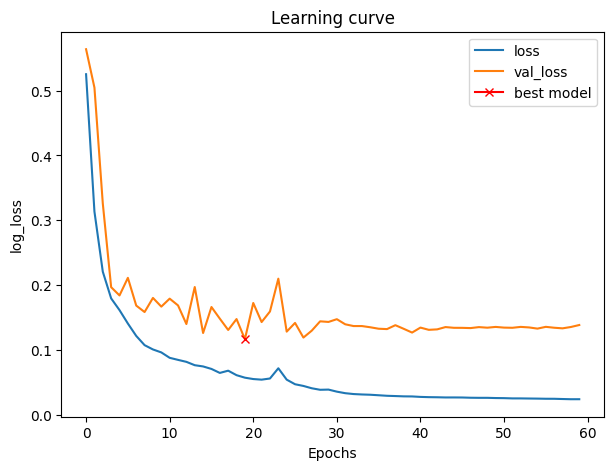

In [22]:
# Plot learning curve
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.title("Learning curve")
plt.plot(history["loss"], label="loss")
plt.plot(history["val_loss"], label="val_loss")
plt.plot(np.argmin(history["val_loss"]),
        np.min(history["val_loss"]),
        marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

1/1 [==============================] - 3s 3s/step - loss: 0.0528 - accuracy: 0.9833
Accuracy on test: 0.9832677841186523


(array([4040909.,   56907.,   31049.,   23778.,   22879.,   24818.,
          29616.,   39678.,   99345., 8541613.]),
 array([9.52916525e-06, 9.99572203e-02, 1.99904919e-01, 2.99852610e-01,
        3.99800301e-01, 4.99747992e-01, 5.99695683e-01, 6.99643373e-01,
        7.99591064e-01, 8.99538755e-01, 9.99486446e-01]),
 <BarContainer object of 10 artists>)

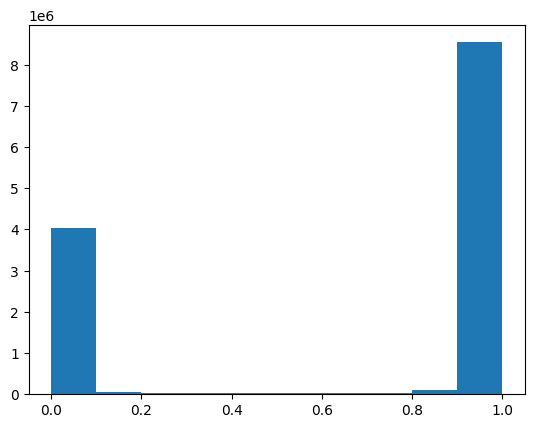

In [25]:
# Compute predicted probabilites everywhere; evaluate on test
probs = model.predict(image, verbose=1)
(test_loss, test_accuracy) = model.evaluate(image[test], mask[test])
print(f'Accuracy on test: {test_accuracy}')
plt.hist(probs.ravel())

In [26]:
# Save the training history and model predictions
pdhistory = pd.DataFrame(history)
pdhistory.to_csv("result_history.csv")
np.savez("probs.npz", probs, test_loss, test_accuracy)

In [27]:
# Display running time and disconnect
end_time = time.time()
min, sec = divmod(int(end_time - start_time), 60)
print(f"Total execution time: {min}:{sec:02}")

Total execution time: 6:32


In [28]:
from google.colab import runtime
runtime.unassign()